### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.record.series import RecordSeries
from python.dev.event.record import Record
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import AToken

In [2]:
time0 = time.time()

In [3]:
APY = 0.1
rec = Record(Deposit(0,0,0))
record_series = RecordSeries(time0)

for k in range(320):
    delta = np.random.gamma(1, 10)   
    select = np.random.choice(2, 1, p=[0.70, 0.30])[0]
    t_delta = np.random.negative_binomial(1, 0.00001)
      
    if(select == 0): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    rec.update_event(event)
    record_series.add_record(rec)
    
    #print('{} {}'.format(rec.get_principle(),rec.get_balance() )) 

principle = record_series.get_principle() 
balance = record_series.get_balance() 
tSamp = record_series.get_tstamp()

In [4]:
for k in range(10):
    type_event = record_series.get_record(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event,tSamp[k]))

0: DEPOSIT @ 2022-04-17 08:21:48.872118
1: DEPOSIT @ 2022-04-18 03:32:25.872118
2: DEPOSIT @ 2022-04-18 08:38:01.872118
3: WITHDRAW @ 2022-04-19 02:43:34.872118
4: DEPOSIT @ 2022-04-19 13:21:04.872118
5: DEPOSIT @ 2022-04-19 14:16:30.872118
6: DEPOSIT @ 2022-04-19 15:18:50.872118
7: WITHDRAW @ 2022-04-21 10:11:46.872118
8: WITHDRAW @ 2022-04-22 11:35:04.872118
9: DEPOSIT @ 2022-04-23 05:16:42.872118


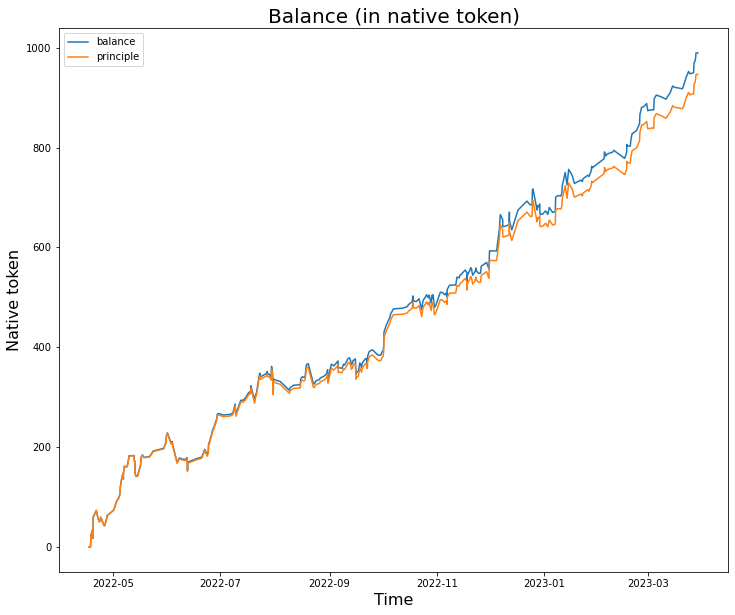

In [5]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


In [7]:
# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

T1 = AToken(TYPE_DEPOSIT_TOKEN)
t_delta = np.random.negative_binomial(1, 0.00001)
depositT1 = np.random.gamma(2, 2000, 1)[0]
t1Address = T1.gen_address()
T1.init_address(time0, t1Address)
T1.add_event(Deposit(APY, depositT1, t_delta, t1Address))

TDT = AToken(TYPE_DEBT_TOKEN)
t_delta = np.random.negative_binomial(1, 0.00001)
depositTDT = np.random.gamma(2, 2000, 1)[0]
tdtAddress = TDT.gen_address()
TDT.init_address(time0, tdtAddress)
TDT.add_event(Deposit(APY, depositTDT, t_delta, tdtAddress))


x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}'.format(x,y))

native_T1_rate = 2 # native -> T1
native_TDT_rate = 5  # native -> TDT

x = Convert(native_T1_rate).apply(x)
y = Convert(native_TDT_rate).apply(y)

# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)
plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, 'L = {}, p = {}'.format(int(L),p))

for k in range(200):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = cpt.random_delta(500)
    t_delta = np.random.negative_binomial(1, 0.00001)

    select = np.random.choice(2, 1, p=[0.50, 0.50])[0]
    if(select == 0): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress))        
        
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))         
        
    delta_x = Convert(1/native_T1_rate).apply(delta_x)

    L = liq.update(delta_x); p = np.random.normal(5,0.1,1)[0]
    plotCurve.apply_next(p, L, 'L = {}, p = {}'.format(int(L),p))
    plotCurve.plot_trade(p, delta_x, 'r--')

    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()

    #print('[Trade {}] T1: {:.2f} TDT: {:.2f}'.format(k,x,y))



KeyError: 'ebdfb7f7c3a445b59cb005db5e7ffb36'

In [ ]:
T1_records = T1.get_record_series(t1Address)
principle = T1_records.get_principle() 
balance = T1_records.get_balance() 
tSamp = T1_records.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_records = TDT.get_record_series(tdtAddress)
principle = TDT_records.get_principle() 
balance = TDT_records.get_balance() 
tSamp = TDT_records.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()